In [23]:
import os
import numpy as np
from PIL import Image  # Import the Image module
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
class CustomDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        image_path = self.file_paths[idx]
        # Load the image
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]
        
        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)

        return image, label


In [5]:
# Define data preprocessing function
def preprocess_image(image):
    # Implement image preprocessing (resize, normalization, augmentation)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        # Add more augmentation techniques here if needed
    ])
    return transform(image)


In [6]:
# Define dataset directory
dataset_dir = "./train_mel_spectogram_images"

# Initialize lists to store file paths and labels
file_paths = []
labels = []

# Convert file_paths into a Python list
# file_paths = file_paths.tolist()

In [7]:
# Traverse through each subfolder in the dataset directory
for label in os.listdir(dataset_dir):
    label_dir = os.path.join(dataset_dir, label)
    if os.path.isdir(label_dir):
        # For each image file in the subfolder, append its path to file_paths
        for filename in os.listdir(label_dir):
            image_path = os.path.join(label_dir, filename)
            file_paths.append(image_path)

In [9]:
# Initialize an empty list to store labels
label_list = []

# Loop through file paths to extract labels
for file_path in file_paths:
    # Extract label from file path (modify this based on your file naming convention)
    label = file_path.split("\\")[-2]  # Use "\\" for Windows-style file paths
    label_list.append(label)

# # Print the extracted labels and their dimensions
# print("Extracted Labels:", label_list)
# print("Label List Dimensions:", len(label_list))

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit the encoder to the labels and transform the labels to numerical values
encoded_labels = label_encoder.fit_transform(label_list)

# Convert the list of encoded labels to a tensor
labels = torch.tensor(encoded_labels, dtype=torch.long)
labels = [label.item() for label in labels]

In [10]:
# Convert lists to numpy arrays
file_paths = np.array(file_paths)
labels = torch.tensor(labels, dtype=torch.long)

In [11]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to (224, 224)
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

In [12]:
# Split the dataset into training and validation sets
train_file_paths, val_file_paths, train_labels, val_labels = train_test_split(file_paths, labels, test_size=0.2, random_state=42)

# Create training and validation datasets
train_dataset = CustomDataset(train_file_paths, train_labels, transform=transform)
val_dataset = CustomDataset(val_file_paths, val_labels, transform=transform)

# Create dataloaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [13]:
# Define ResNet50 model with modifications
class ModifiedResNet50(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedResNet50, self).__init__()
        self.resnet50 = models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V1')
        # Modify the fully connected layer
        num_ftrs = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Sequential(
            nn.Linear(num_ftrs, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        return self.resnet50(x)

In [14]:
num_classes = 0
for item in os.listdir('./train_mel_spectogram_images'):
        if os.path.isdir(os.path.join('./train_mel_spectogram_images', item)):
            num_classes += 1
print(num_classes)
model = ModifiedResNet50(num_classes=num_classes).to(device)

40


In [15]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
# Initialize lists to store predictions and labels for each fold
train_predictions_lists = []
val_predictions_lists = []
train_labels_lists = []
val_labels_lists = []
train_accuracy_lists = []
val_accuracy_lists = []
train_precision_lists = []
val_precision_lists = []
train_recall_lists = []
val_recall_lists = []
train_f1_lists = []
val_f1_lists = []

# Define k
k = 5
batch_size = 32
num_epochs = 30
# K-fold cross-validation
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
X = file_paths
y = encoded_labels
for fold, (train_index, val_index) in enumerate(skf.split(X, y), start=1):
    print(f"Fold {fold}/{k}\n")

    # Split data into train and validation sets
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Create data loaders for training and validation
    train_dataset = CustomDataset(X_train, y_train, transform=transform)
    val_dataset = CustomDataset(X_val, y_val, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize lists to store predictions and labels for each epoch
    train_predictions_list = []
    val_predictions_list = []
    train_labels_list = []
    val_labels_list = []
    train_accuracy_list = []
    val_accuracy_list = []
    train_precision_list = []
    val_precision_list = []
    train_recall_list = []
    val_recall_list = []
    train_f1_list = []
    val_f1_list = []

    # Train the model
    for epoch in range(1, num_epochs+1):
        print(f"Epoch {epoch}/{num_epochs}")
        model.train()
        total_train = 0
        correct_train = 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            # Store training predictions and labels
            train_predictions_list.extend(predicted.cpu().numpy())
            train_labels_list.extend(labels.cpu().numpy())

        # Validation loop
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                # Store validation predictions and labels
                val_predictions_list.extend(predicted.cpu().numpy())
                val_labels_list.extend(labels.cpu().numpy())

        # Calculate metrics for training set
        train_accuracy = 100 * correct_train / total_train
        train_precision = precision_score(train_labels_list, train_predictions_list, average='weighted', zero_division=0)
        train_recall = recall_score(train_labels_list, train_predictions_list, average='weighted', zero_division=0)
        train_f1 = f1_score(train_labels_list, train_predictions_list, average='weighted',  zero_division=0)
        # Append metrics to lists
        train_accuracy_list.append(train_accuracy)
        train_precision_list.append(train_precision)
        train_recall_list.append(train_recall)
        train_f1_list.append(train_f1)

        # Calculate metrics for validation set
        val_accuracy = 100 * correct_val / total_val
        val_precision = precision_score(val_labels_list, val_predictions_list, average='weighted', zero_division=0)
        val_recall = recall_score(val_labels_list, val_predictions_list, average='weighted', zero_division=0)
        val_f1 = f1_score(val_labels_list, val_predictions_list, average='weighted', zero_division=0)
        # Append metrics to lists
        val_accuracy_list.append(val_accuracy)
        val_precision_list.append(val_precision)
        val_recall_list.append(val_recall)
        val_f1_list.append(val_f1)

        print(f'Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%')

    # Append metrics lists for this fold to overall lists
    train_predictions_lists.append(train_predictions_list)
    val_predictions_lists.append(val_predictions_list)
    train_labels_lists.append(train_labels_list)
    val_labels_lists.append(val_labels_list)
    train_accuracy_lists.append(train_accuracy_list)
    val_accuracy_lists.append(val_accuracy_list)
    train_precision_lists.append(train_precision_list)
    val_precision_lists.append(val_precision_list)
    train_recall_lists.append(train_recall_list)
    val_recall_lists.append(val_recall_list)
    train_f1_lists.append(train_f1_list)
    val_f1_lists.append(val_f1_list)
    print("\n\n")

Fold 1/5

Epoch 1/30


100%|██████████| 16/16 [00:05<00:00,  2.79it/s]


Training Accuracy: 2.18%, Validation Accuracy: 2.63%
Epoch 2/30


100%|██████████| 16/16 [00:04<00:00,  3.21it/s]


Training Accuracy: 2.69%, Validation Accuracy: 3.64%
Epoch 3/30


100%|██████████| 16/16 [00:04<00:00,  3.25it/s]


Training Accuracy: 3.50%, Validation Accuracy: 3.44%
Epoch 4/30


100%|██████████| 16/16 [00:04<00:00,  3.21it/s]


Training Accuracy: 3.45%, Validation Accuracy: 3.44%
Epoch 5/30


100%|██████████| 16/16 [00:04<00:00,  3.23it/s]


Training Accuracy: 2.99%, Validation Accuracy: 4.25%
Epoch 6/30


100%|██████████| 16/16 [00:05<00:00,  3.17it/s]


Training Accuracy: 3.85%, Validation Accuracy: 3.64%
Epoch 7/30


100%|██████████| 16/16 [00:04<00:00,  3.21it/s]


Training Accuracy: 3.90%, Validation Accuracy: 3.24%
Epoch 8/30


100%|██████████| 16/16 [00:05<00:00,  3.15it/s]


Training Accuracy: 3.80%, Validation Accuracy: 3.64%
Epoch 9/30


100%|██████████| 16/16 [00:05<00:00,  2.83it/s]


Training Accuracy: 4.11%, Validation Accuracy: 3.85%
Epoch 10/30


100%|██████████| 16/16 [00:05<00:00,  2.71it/s]


Training Accuracy: 4.51%, Validation Accuracy: 3.85%
Epoch 11/30


100%|██████████| 16/16 [00:05<00:00,  2.89it/s]


Training Accuracy: 4.77%, Validation Accuracy: 4.05%
Epoch 12/30


100%|██████████| 16/16 [00:05<00:00,  2.80it/s]


Training Accuracy: 4.26%, Validation Accuracy: 4.86%
Epoch 13/30


100%|██████████| 16/16 [00:05<00:00,  2.70it/s]


Training Accuracy: 4.11%, Validation Accuracy: 3.44%
Epoch 14/30


100%|██████████| 16/16 [00:07<00:00,  2.22it/s]


Training Accuracy: 4.67%, Validation Accuracy: 4.05%
Epoch 15/30


100%|██████████| 16/16 [00:07<00:00,  2.25it/s]


Training Accuracy: 4.92%, Validation Accuracy: 3.44%
Epoch 16/30


100%|██████████| 16/16 [00:07<00:00,  2.21it/s]


Training Accuracy: 5.27%, Validation Accuracy: 3.85%
Epoch 17/30


100%|██████████| 16/16 [00:07<00:00,  2.23it/s]


Training Accuracy: 4.61%, Validation Accuracy: 3.44%
Epoch 18/30


100%|██████████| 16/16 [00:07<00:00,  2.27it/s]


Training Accuracy: 5.32%, Validation Accuracy: 3.04%
Epoch 19/30


100%|██████████| 16/16 [00:06<00:00,  2.29it/s]


Training Accuracy: 4.82%, Validation Accuracy: 3.24%
Epoch 20/30


100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Training Accuracy: 5.22%, Validation Accuracy: 4.05%
Epoch 21/30


100%|██████████| 16/16 [00:06<00:00,  2.30it/s]


Training Accuracy: 5.68%, Validation Accuracy: 4.05%
Epoch 22/30


100%|██████████| 16/16 [00:07<00:00,  2.26it/s]


Training Accuracy: 5.07%, Validation Accuracy: 3.85%
Epoch 23/30


100%|██████████| 16/16 [00:06<00:00,  2.31it/s]


Training Accuracy: 5.83%, Validation Accuracy: 2.83%
Epoch 24/30


100%|██████████| 16/16 [00:06<00:00,  2.29it/s]


Training Accuracy: 5.48%, Validation Accuracy: 4.66%
Epoch 25/30


100%|██████████| 16/16 [00:06<00:00,  2.32it/s]


Training Accuracy: 7.05%, Validation Accuracy: 3.24%
Epoch 26/30


100%|██████████| 16/16 [00:07<00:00,  2.12it/s]


Training Accuracy: 6.39%, Validation Accuracy: 4.45%
Epoch 27/30


100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Training Accuracy: 6.09%, Validation Accuracy: 3.85%
Epoch 28/30


100%|██████████| 16/16 [00:06<00:00,  2.31it/s]


Training Accuracy: 6.74%, Validation Accuracy: 4.05%
Epoch 29/30


100%|██████████| 16/16 [00:07<00:00,  2.27it/s]


Training Accuracy: 6.19%, Validation Accuracy: 3.64%
Epoch 30/30


100%|██████████| 16/16 [00:07<00:00,  2.25it/s]


Training Accuracy: 6.59%, Validation Accuracy: 3.64%



Fold 2/5

Epoch 1/30


100%|██████████| 16/16 [00:07<00:00,  2.17it/s]


Training Accuracy: 5.42%, Validation Accuracy: 5.88%
Epoch 2/30


100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Training Accuracy: 6.13%, Validation Accuracy: 4.67%
Epoch 3/30


100%|██████████| 16/16 [00:07<00:00,  2.23it/s]


Training Accuracy: 6.13%, Validation Accuracy: 5.27%
Epoch 4/30


100%|██████████| 16/16 [00:07<00:00,  2.27it/s]


Training Accuracy: 5.83%, Validation Accuracy: 5.48%
Epoch 5/30


100%|██████████| 16/16 [00:07<00:00,  2.16it/s]


Training Accuracy: 6.49%, Validation Accuracy: 4.67%
Epoch 6/30


100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Training Accuracy: 7.10%, Validation Accuracy: 5.68%
Epoch 7/30


100%|██████████| 16/16 [00:06<00:00,  2.29it/s]


Training Accuracy: 6.34%, Validation Accuracy: 4.87%
Epoch 8/30


100%|██████████| 16/16 [00:07<00:00,  2.24it/s]


Training Accuracy: 6.28%, Validation Accuracy: 4.26%
Epoch 9/30


100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Training Accuracy: 6.18%, Validation Accuracy: 4.87%
Epoch 10/30


100%|██████████| 16/16 [00:07<00:00,  2.25it/s]


Training Accuracy: 7.40%, Validation Accuracy: 5.68%
Epoch 11/30


100%|██████████| 16/16 [00:07<00:00,  2.28it/s]


Training Accuracy: 8.36%, Validation Accuracy: 4.46%
Epoch 12/30


100%|██████████| 16/16 [00:07<00:00,  2.26it/s]


Training Accuracy: 8.06%, Validation Accuracy: 5.27%
Epoch 13/30


100%|██████████| 16/16 [00:07<00:00,  2.28it/s]


Training Accuracy: 7.75%, Validation Accuracy: 5.48%
Epoch 14/30


100%|██████████| 16/16 [00:06<00:00,  2.32it/s]


Training Accuracy: 7.91%, Validation Accuracy: 3.65%
Epoch 15/30


100%|██████████| 16/16 [00:06<00:00,  2.30it/s]


Training Accuracy: 9.17%, Validation Accuracy: 4.67%
Epoch 16/30


100%|██████████| 16/16 [00:06<00:00,  2.31it/s]


Training Accuracy: 8.31%, Validation Accuracy: 4.87%
Epoch 17/30


100%|██████████| 16/16 [00:07<00:00,  2.28it/s]


Training Accuracy: 9.07%, Validation Accuracy: 4.06%
Epoch 18/30


100%|██████████| 16/16 [00:13<00:00,  1.19it/s]


Training Accuracy: 8.87%, Validation Accuracy: 3.45%
Epoch 19/30


100%|██████████| 16/16 [00:13<00:00,  1.18it/s]


Training Accuracy: 9.28%, Validation Accuracy: 4.06%
Epoch 20/30


100%|██████████| 16/16 [00:13<00:00,  1.15it/s]


Training Accuracy: 9.73%, Validation Accuracy: 4.26%
Epoch 21/30


100%|██████████| 16/16 [00:14<00:00,  1.10it/s]


Training Accuracy: 9.58%, Validation Accuracy: 4.87%
Epoch 22/30


100%|██████████| 16/16 [00:13<00:00,  1.17it/s]


Training Accuracy: 10.29%, Validation Accuracy: 4.46%
Epoch 23/30


100%|██████████| 16/16 [00:13<00:00,  1.15it/s]


Training Accuracy: 11.91%, Validation Accuracy: 3.45%
Epoch 24/30


100%|██████████| 16/16 [00:13<00:00,  1.15it/s]


Training Accuracy: 11.91%, Validation Accuracy: 3.45%
Epoch 25/30


100%|██████████| 16/16 [00:04<00:00,  3.27it/s]


Training Accuracy: 14.24%, Validation Accuracy: 3.04%
Epoch 26/30


100%|██████████| 16/16 [00:05<00:00,  3.18it/s]


Training Accuracy: 13.99%, Validation Accuracy: 3.45%
Epoch 27/30


100%|██████████| 16/16 [00:05<00:00,  3.03it/s]


Training Accuracy: 14.19%, Validation Accuracy: 3.45%
Epoch 28/30


100%|██████████| 16/16 [00:04<00:00,  3.26it/s]


Training Accuracy: 15.26%, Validation Accuracy: 3.45%
Epoch 29/30


100%|██████████| 16/16 [00:04<00:00,  3.27it/s]


Training Accuracy: 18.25%, Validation Accuracy: 4.26%
Epoch 30/30


100%|██████████| 16/16 [00:04<00:00,  3.29it/s]


Training Accuracy: 16.93%, Validation Accuracy: 4.67%



Fold 3/5

Epoch 1/30


100%|██████████| 16/16 [00:05<00:00,  3.15it/s]


Training Accuracy: 13.74%, Validation Accuracy: 17.85%
Epoch 2/30


100%|██████████| 16/16 [00:05<00:00,  3.19it/s]


Training Accuracy: 15.46%, Validation Accuracy: 17.04%
Epoch 3/30


100%|██████████| 16/16 [00:05<00:00,  2.90it/s]


Training Accuracy: 17.03%, Validation Accuracy: 17.65%
Epoch 4/30


100%|██████████| 16/16 [00:05<00:00,  2.72it/s]


Training Accuracy: 19.16%, Validation Accuracy: 16.43%
Epoch 5/30


100%|██████████| 16/16 [00:06<00:00,  2.66it/s]


Training Accuracy: 19.61%, Validation Accuracy: 15.01%
Epoch 6/30


100%|██████████| 16/16 [00:06<00:00,  2.59it/s]


Training Accuracy: 20.22%, Validation Accuracy: 14.81%
Epoch 7/30


100%|██████████| 16/16 [00:05<00:00,  2.75it/s]


Training Accuracy: 22.76%, Validation Accuracy: 12.78%
Epoch 8/30


100%|██████████| 16/16 [00:05<00:00,  2.79it/s]


Training Accuracy: 24.89%, Validation Accuracy: 14.60%
Epoch 9/30


100%|██████████| 16/16 [00:05<00:00,  2.74it/s]


Training Accuracy: 27.27%, Validation Accuracy: 13.59%
Epoch 10/30


100%|██████████| 16/16 [00:05<00:00,  2.70it/s]


Training Accuracy: 29.30%, Validation Accuracy: 12.58%
Epoch 11/30


100%|██████████| 16/16 [00:05<00:00,  2.78it/s]


Training Accuracy: 30.26%, Validation Accuracy: 10.55%
Epoch 12/30


100%|██████████| 16/16 [00:05<00:00,  2.95it/s]


Training Accuracy: 32.18%, Validation Accuracy: 12.58%
Epoch 13/30


100%|██████████| 16/16 [00:05<00:00,  2.92it/s]


Training Accuracy: 34.62%, Validation Accuracy: 11.56%
Epoch 14/30


100%|██████████| 16/16 [00:05<00:00,  2.73it/s]


Training Accuracy: 36.19%, Validation Accuracy: 13.18%
Epoch 15/30


100%|██████████| 16/16 [00:05<00:00,  2.80it/s]


Training Accuracy: 37.96%, Validation Accuracy: 13.39%
Epoch 16/30


100%|██████████| 16/16 [00:05<00:00,  2.83it/s]


Training Accuracy: 40.29%, Validation Accuracy: 12.17%
Epoch 17/30


100%|██████████| 16/16 [00:05<00:00,  2.84it/s]


Training Accuracy: 41.05%, Validation Accuracy: 11.16%
Epoch 18/30


100%|██████████| 16/16 [00:05<00:00,  2.88it/s]


Training Accuracy: 45.72%, Validation Accuracy: 9.53%
Epoch 19/30


100%|██████████| 16/16 [00:05<00:00,  2.89it/s]


Training Accuracy: 43.44%, Validation Accuracy: 9.33%
Epoch 20/30


100%|██████████| 16/16 [00:05<00:00,  2.90it/s]


Training Accuracy: 47.69%, Validation Accuracy: 10.34%
Epoch 21/30


100%|██████████| 16/16 [00:05<00:00,  2.94it/s]


Training Accuracy: 46.22%, Validation Accuracy: 10.75%
Epoch 22/30


100%|██████████| 16/16 [00:05<00:00,  2.97it/s]


Training Accuracy: 51.34%, Validation Accuracy: 11.16%
Epoch 23/30


100%|██████████| 16/16 [00:05<00:00,  2.95it/s]


Training Accuracy: 52.61%, Validation Accuracy: 11.36%
Epoch 24/30


100%|██████████| 16/16 [00:05<00:00,  2.89it/s]


Training Accuracy: 54.23%, Validation Accuracy: 11.56%
Epoch 25/30


100%|██████████| 16/16 [00:05<00:00,  2.90it/s]


Training Accuracy: 56.31%, Validation Accuracy: 10.55%
Epoch 26/30


100%|██████████| 16/16 [00:05<00:00,  2.95it/s]


Training Accuracy: 55.75%, Validation Accuracy: 9.13%
Epoch 27/30


100%|██████████| 16/16 [00:05<00:00,  2.98it/s]


Training Accuracy: 57.93%, Validation Accuracy: 10.55%
Epoch 28/30


100%|██████████| 16/16 [00:05<00:00,  2.92it/s]


Training Accuracy: 59.00%, Validation Accuracy: 9.13%
Epoch 29/30


100%|██████████| 16/16 [00:05<00:00,  2.94it/s]


Training Accuracy: 61.23%, Validation Accuracy: 6.90%
Epoch 30/30


100%|██████████| 16/16 [00:05<00:00,  2.80it/s]


Training Accuracy: 60.62%, Validation Accuracy: 10.34%



Fold 4/5

Epoch 1/30


100%|██████████| 16/16 [00:05<00:00,  2.90it/s]


Training Accuracy: 41.71%, Validation Accuracy: 57.61%
Epoch 2/30


100%|██████████| 16/16 [00:05<00:00,  2.96it/s]


Training Accuracy: 49.47%, Validation Accuracy: 69.57%
Epoch 3/30


100%|██████████| 16/16 [00:05<00:00,  2.95it/s]


Training Accuracy: 55.60%, Validation Accuracy: 63.49%
Epoch 4/30


100%|██████████| 16/16 [00:05<00:00,  2.92it/s]


Training Accuracy: 57.58%, Validation Accuracy: 58.42%
Epoch 5/30


100%|██████████| 16/16 [00:05<00:00,  2.94it/s]


Training Accuracy: 60.87%, Validation Accuracy: 66.13%
Epoch 6/30


100%|██████████| 16/16 [00:05<00:00,  2.92it/s]


Training Accuracy: 62.90%, Validation Accuracy: 61.26%
Epoch 7/30


100%|██████████| 16/16 [00:06<00:00,  2.53it/s]


Training Accuracy: 62.60%, Validation Accuracy: 57.20%
Epoch 8/30


100%|██████████| 16/16 [00:09<00:00,  1.73it/s]


Training Accuracy: 65.08%, Validation Accuracy: 57.81%
Epoch 9/30


100%|██████████| 16/16 [00:05<00:00,  2.86it/s]


Training Accuracy: 66.24%, Validation Accuracy: 63.49%
Epoch 10/30


100%|██████████| 16/16 [00:05<00:00,  2.82it/s]


Training Accuracy: 70.50%, Validation Accuracy: 54.77%
Epoch 11/30


100%|██████████| 16/16 [00:05<00:00,  2.84it/s]


Training Accuracy: 71.21%, Validation Accuracy: 54.16%
Epoch 12/30


100%|██████████| 16/16 [00:05<00:00,  2.68it/s]


Training Accuracy: 74.61%, Validation Accuracy: 51.52%
Epoch 13/30


100%|██████████| 16/16 [00:05<00:00,  2.76it/s]


Training Accuracy: 75.16%, Validation Accuracy: 55.98%
Epoch 14/30


100%|██████████| 16/16 [00:05<00:00,  2.79it/s]


Training Accuracy: 74.30%, Validation Accuracy: 54.16%
Epoch 15/30


100%|██████████| 16/16 [00:05<00:00,  2.82it/s]


Training Accuracy: 75.22%, Validation Accuracy: 49.70%
Epoch 16/30


100%|██████████| 16/16 [00:05<00:00,  2.81it/s]


Training Accuracy: 75.92%, Validation Accuracy: 45.64%
Epoch 17/30


100%|██████████| 16/16 [00:05<00:00,  2.85it/s]


Training Accuracy: 76.28%, Validation Accuracy: 51.32%
Epoch 18/30


100%|██████████| 16/16 [00:05<00:00,  2.78it/s]


Training Accuracy: 78.76%, Validation Accuracy: 53.35%
Epoch 19/30


100%|██████████| 16/16 [00:07<00:00,  2.07it/s]


Training Accuracy: 78.61%, Validation Accuracy: 51.93%
Epoch 20/30


100%|██████████| 16/16 [00:07<00:00,  2.14it/s]


Training Accuracy: 80.99%, Validation Accuracy: 52.33%
Epoch 21/30


100%|██████████| 16/16 [00:04<00:00,  3.24it/s]


Training Accuracy: 81.45%, Validation Accuracy: 47.67%
Epoch 22/30


100%|██████████| 16/16 [00:05<00:00,  3.16it/s]


Training Accuracy: 81.80%, Validation Accuracy: 43.20%
Epoch 23/30


100%|██████████| 16/16 [00:05<00:00,  2.77it/s]


Training Accuracy: 83.12%, Validation Accuracy: 50.71%
Epoch 24/30


100%|██████████| 16/16 [00:05<00:00,  2.71it/s]


Training Accuracy: 85.25%, Validation Accuracy: 41.78%
Epoch 25/30


100%|██████████| 16/16 [00:06<00:00,  2.62it/s]


Training Accuracy: 81.15%, Validation Accuracy: 40.16%
Epoch 26/30


100%|██████████| 16/16 [00:05<00:00,  2.84it/s]


Training Accuracy: 84.14%, Validation Accuracy: 41.99%
Epoch 27/30


100%|██████████| 16/16 [00:04<00:00,  3.23it/s]


Training Accuracy: 82.41%, Validation Accuracy: 45.23%
Epoch 28/30


100%|██████████| 16/16 [00:05<00:00,  2.83it/s]


Training Accuracy: 85.15%, Validation Accuracy: 43.00%
Epoch 29/30


100%|██████████| 16/16 [00:05<00:00,  2.85it/s]


Training Accuracy: 83.93%, Validation Accuracy: 38.34%
Epoch 30/30


100%|██████████| 16/16 [00:05<00:00,  2.78it/s]


Training Accuracy: 85.61%, Validation Accuracy: 41.38%



Fold 5/5

Epoch 1/30


100%|██████████| 16/16 [00:05<00:00,  2.84it/s]


Training Accuracy: 69.29%, Validation Accuracy: 86.00%
Epoch 2/30


100%|██████████| 16/16 [00:05<00:00,  2.88it/s]


Training Accuracy: 75.92%, Validation Accuracy: 90.26%
Epoch 3/30


100%|██████████| 16/16 [00:05<00:00,  2.79it/s]


Training Accuracy: 79.78%, Validation Accuracy: 93.91%
Epoch 4/30


100%|██████████| 16/16 [00:05<00:00,  2.85it/s]


Training Accuracy: 81.65%, Validation Accuracy: 85.60%
Epoch 5/30


100%|██████████| 16/16 [00:05<00:00,  2.85it/s]


Training Accuracy: 83.17%, Validation Accuracy: 87.63%
Epoch 6/30


100%|██████████| 16/16 [00:05<00:00,  2.89it/s]


Training Accuracy: 84.14%, Validation Accuracy: 91.68%
Epoch 7/30


100%|██████████| 16/16 [00:05<00:00,  2.91it/s]


Training Accuracy: 86.21%, Validation Accuracy: 81.34%
Epoch 8/30


100%|██████████| 16/16 [00:05<00:00,  2.98it/s]


Training Accuracy: 85.50%, Validation Accuracy: 86.00%
Epoch 9/30


100%|██████████| 16/16 [00:05<00:00,  2.94it/s]


Training Accuracy: 87.13%, Validation Accuracy: 86.61%
Epoch 10/30


100%|██████████| 16/16 [00:05<00:00,  2.95it/s]


Training Accuracy: 87.73%, Validation Accuracy: 87.42%
Epoch 11/30


100%|██████████| 16/16 [00:05<00:00,  2.95it/s]


Training Accuracy: 85.91%, Validation Accuracy: 79.51%
Epoch 12/30


100%|██████████| 16/16 [00:05<00:00,  2.97it/s]


Training Accuracy: 86.16%, Validation Accuracy: 84.38%
Epoch 13/30


100%|██████████| 16/16 [00:05<00:00,  2.81it/s]


Training Accuracy: 86.52%, Validation Accuracy: 84.18%
Epoch 14/30


100%|██████████| 16/16 [00:05<00:00,  2.87it/s]


Training Accuracy: 88.85%, Validation Accuracy: 86.61%
Epoch 15/30


100%|██████████| 16/16 [00:05<00:00,  2.88it/s]


Training Accuracy: 88.09%, Validation Accuracy: 88.24%
Epoch 16/30


100%|██████████| 16/16 [00:05<00:00,  2.87it/s]


Training Accuracy: 88.34%, Validation Accuracy: 82.56%
Epoch 17/30


100%|██████████| 16/16 [00:05<00:00,  2.87it/s]


Training Accuracy: 89.91%, Validation Accuracy: 84.99%
Epoch 18/30


100%|██████████| 16/16 [00:05<00:00,  2.83it/s]


Training Accuracy: 90.42%, Validation Accuracy: 86.82%
Epoch 19/30


100%|██████████| 16/16 [00:05<00:00,  2.81it/s]


Training Accuracy: 90.07%, Validation Accuracy: 78.30%
Epoch 20/30


100%|██████████| 16/16 [00:05<00:00,  2.77it/s]


Training Accuracy: 92.09%, Validation Accuracy: 84.79%
Epoch 21/30


100%|██████████| 16/16 [00:05<00:00,  2.88it/s]


Training Accuracy: 91.74%, Validation Accuracy: 80.12%
Epoch 22/30


100%|██████████| 16/16 [00:05<00:00,  2.95it/s]


Training Accuracy: 91.23%, Validation Accuracy: 78.50%
Epoch 23/30


100%|██████████| 16/16 [00:05<00:00,  2.91it/s]


Training Accuracy: 90.67%, Validation Accuracy: 80.73%
Epoch 24/30


100%|██████████| 16/16 [00:05<00:00,  2.95it/s]


Training Accuracy: 90.98%, Validation Accuracy: 82.76%
Epoch 25/30


100%|██████████| 16/16 [00:05<00:00,  2.93it/s]


Training Accuracy: 91.18%, Validation Accuracy: 77.48%
Epoch 26/30


100%|██████████| 16/16 [00:05<00:00,  2.82it/s]


Training Accuracy: 88.24%, Validation Accuracy: 71.81%
Epoch 27/30


100%|██████████| 16/16 [00:05<00:00,  2.86it/s]


Training Accuracy: 90.52%, Validation Accuracy: 78.70%
Epoch 28/30


100%|██████████| 16/16 [00:05<00:00,  2.93it/s]


Training Accuracy: 91.18%, Validation Accuracy: 79.72%
Epoch 29/30


100%|██████████| 16/16 [00:05<00:00,  2.98it/s]


Training Accuracy: 92.60%, Validation Accuracy: 79.51%
Epoch 30/30


100%|██████████| 16/16 [00:05<00:00,  2.87it/s]


Training Accuracy: 91.94%, Validation Accuracy: 76.67%





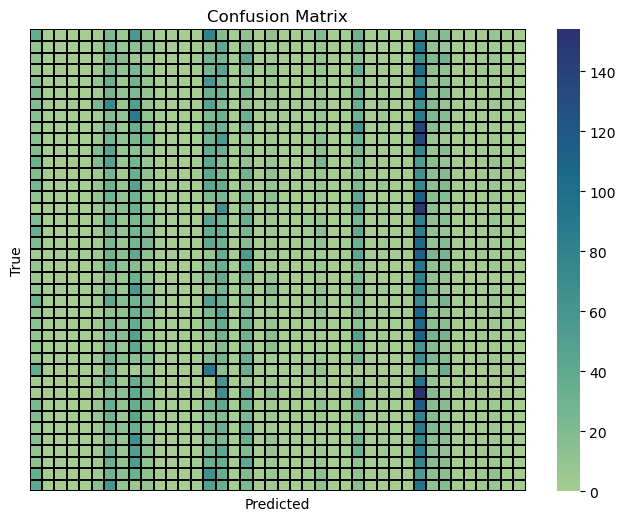

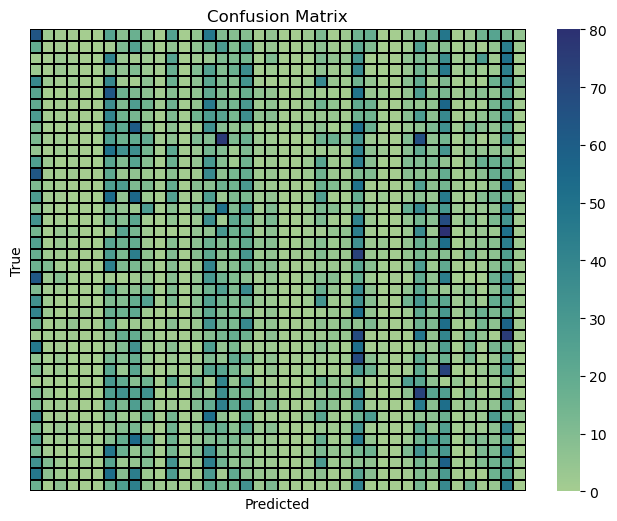

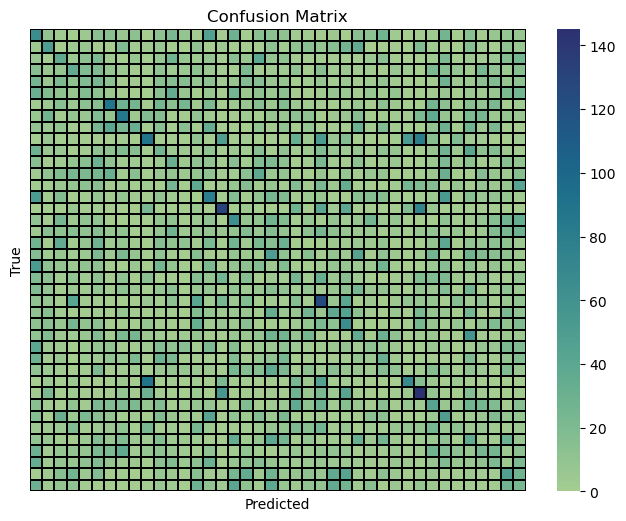

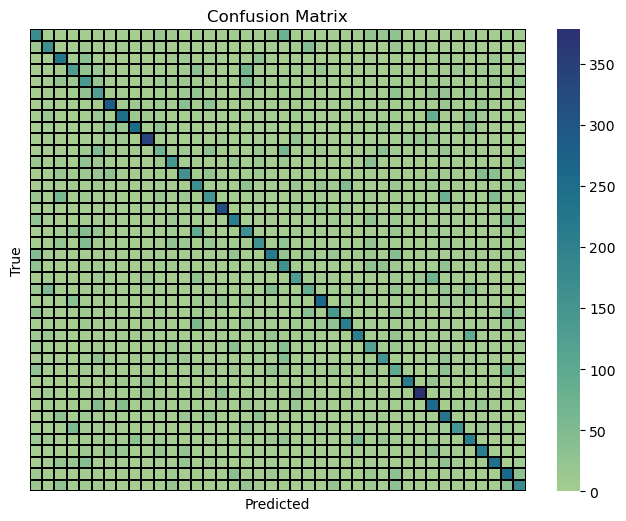

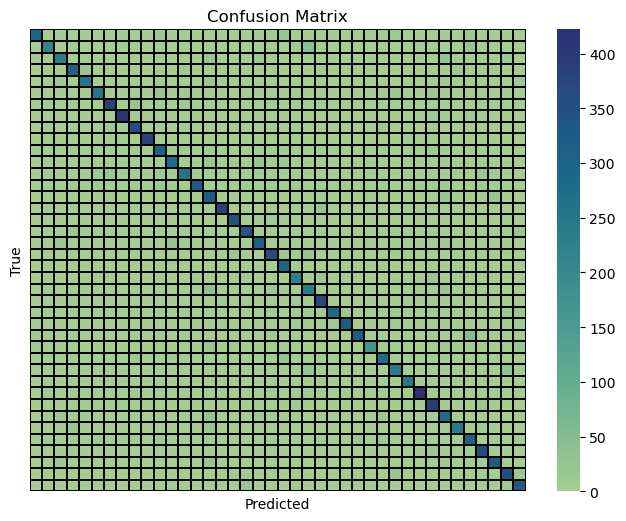

╒════════╤══════════════════╤════════════════╤═══════════════════╤═════════════════╤════════════════╤══════════════╤════════════╤═══════════╤═════════════╤════════════╕
│ Fold   │   Train Accuracy │   Val Accuracy │   Train Precision │   Val Precision │   Train Recall │   Val Recall │   Train F1 │    Val F1 │   Train MCC │    Val MCC │
╞════════╪══════════════════╪════════════════╪═══════════════════╪═════════════════╪════════════════╪══════════════╪════════════╪═══════════╪═════════════╪════════════╡
│ Fold 1 │          4.80223 │        3.7112  │         0.0421838 │       0.0240237 │      0.0480223 │    0.037112  │  0.0325854 │ 0.0201336 │   0.0214586 │ 0.00978928 │
├────────┼──────────────────┼────────────────┼───────────────────┼─────────────────┼────────────────┼──────────────┼────────────┼───────────┼─────────────┼────────────┤
│ Fold 2 │          9.54553 │        4.46924 │         0.0883135 │       0.0409369 │      0.0954553 │    0.0446924 │  0.0780274 │ 0.0349549 │   0.0713437 │

In [30]:
metrics_data = []

for fold in range(5):
    train_labels = train_labels_lists[fold]
    train_predictions = train_predictions_lists[fold]
    val_labels = val_labels_lists[fold]
    val_predictions = val_predictions_lists[fold]

    train_accuracy = accuracy_score(train_labels, train_predictions)
    val_accuracy = accuracy_score(val_labels, val_predictions)
    train_precision = precision_score(train_labels, train_predictions, average='weighted', zero_division=0)
    val_precision = precision_score(val_labels, val_predictions, average='weighted', zero_division=0)
    train_recall = recall_score(train_labels, train_predictions, average='weighted', zero_division=0)
    val_recall = recall_score(val_labels, val_predictions, average='weighted', zero_division=0)
    train_f1 = f1_score(train_labels, train_predictions, average='weighted', zero_division=0)
    val_f1 = f1_score(val_labels, val_predictions, average='weighted', zero_division=0)
    train_mcc = matthews_corrcoef(train_labels, train_predictions)
    val_mcc = matthews_corrcoef(val_labels, val_predictions)

    metrics_data.append([f'Fold {fold+1}', train_accuracy*100, val_accuracy*100, train_precision, val_precision, train_recall, val_recall, train_f1, val_f1, train_mcc, val_mcc])
    
    cm = confusion_matrix(val_labels, val_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, cmap='crest', xticklabels=False, yticklabels=False, linecolor='black', linewidths=0.25)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

headers = ['Fold', 'Train Accuracy', 'Val Accuracy', 'Train Precision', 'Val Precision', 'Train Recall', 'Val Recall', 'Train F1', 'Val F1', 'Train MCC', 'Val MCC']

print(tabulate(metrics_data, headers=headers, tablefmt="fancy_grid"))

In [31]:
def plot_metrics(metric_name):
    train_list_name = eval('train_'+metric_name.split()[0].lower()+'_lists')
    val_list_name = eval('val_'+metric_name.split()[0].lower()+'_lists')
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    for fold in range(1, k+1):
        plt.plot(range(1, len(train_list_name[0]) + 1), train_list_name[fold-1], label=f'Fold {fold}')
    plt.title(f'Training {metric_name} for Each Fold')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    for fold in range(1, k+1):
        plt.plot(range(1, len(val_list_name[0]) + 1), val_list_name[fold-1], label=f'Fold {fold}')
    plt.title(f'Validation {metric_name} for Each Fold')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

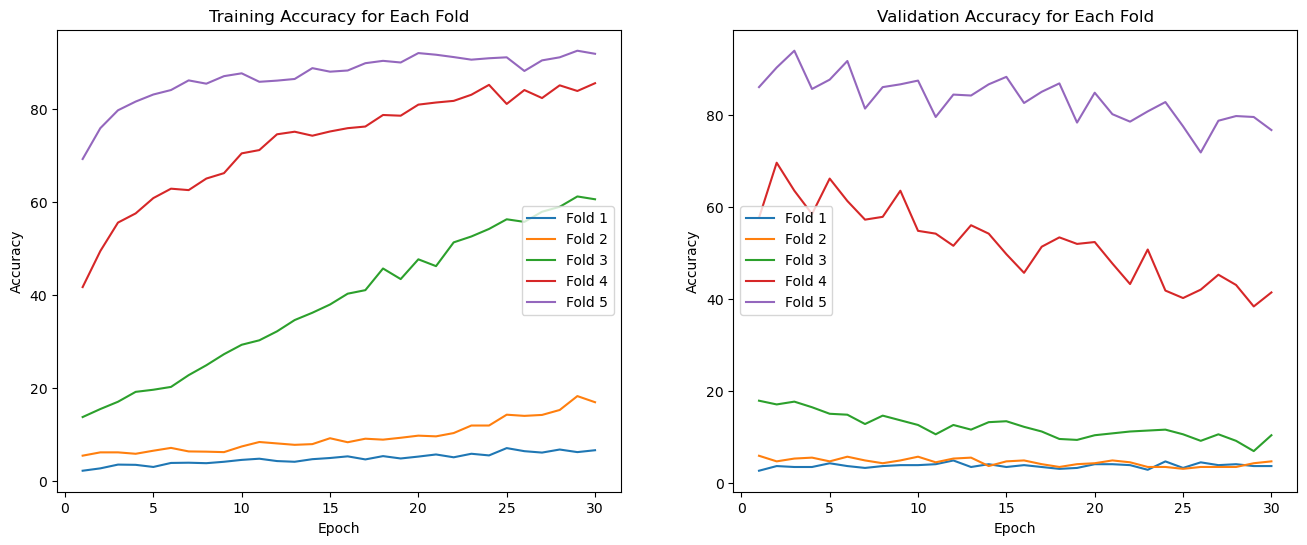

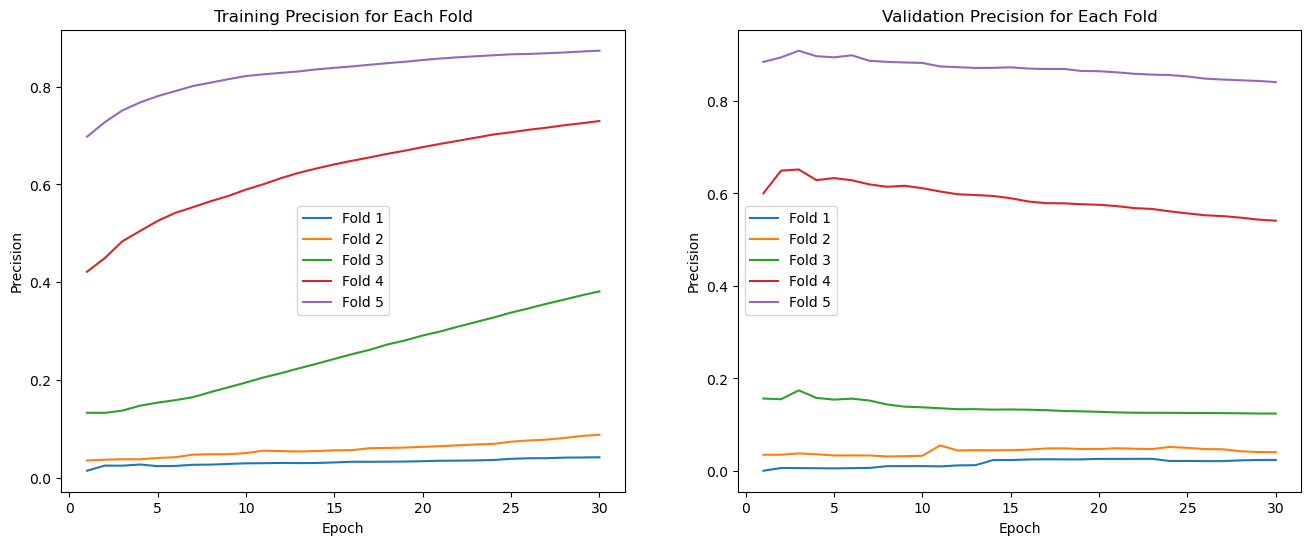

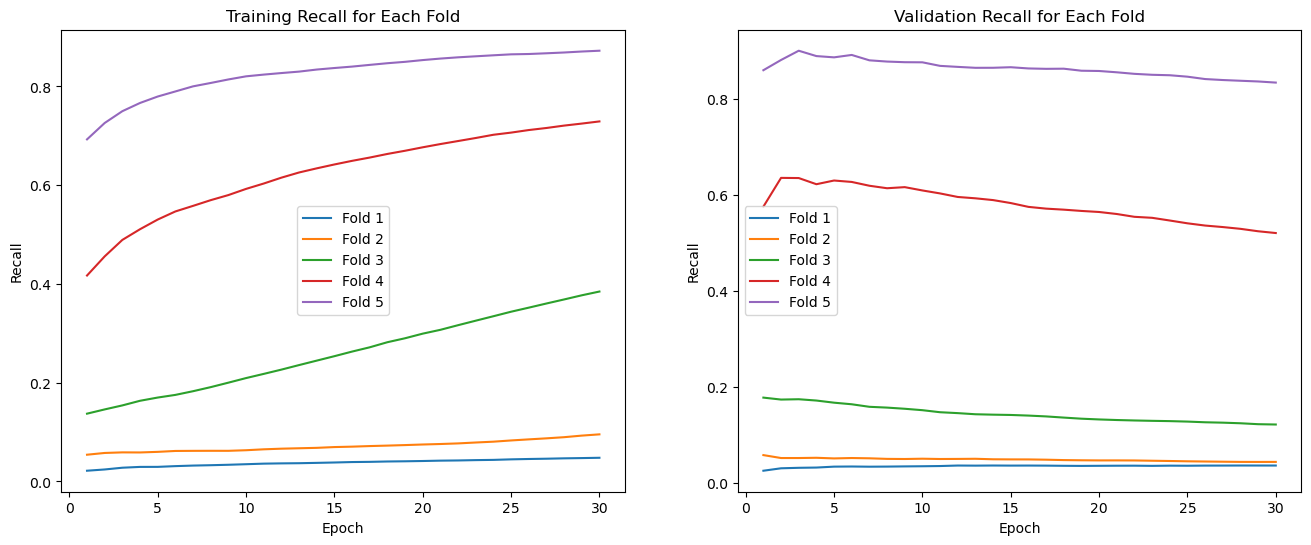

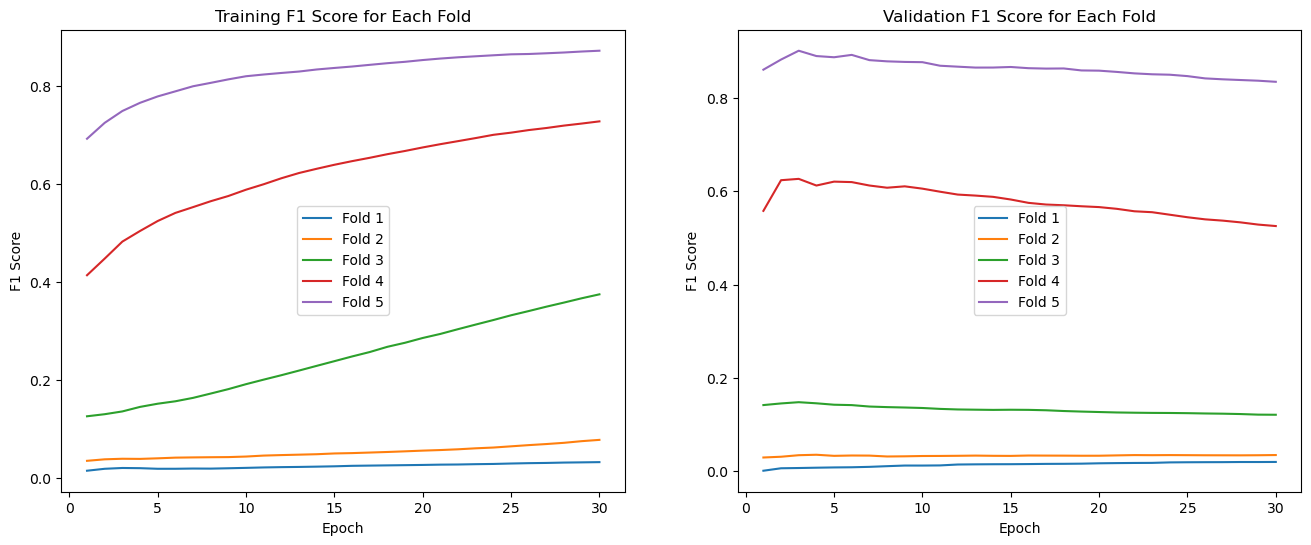

In [36]:
# Plot training and validation metrics
plot_metrics('Accuracy')
plot_metrics('Precision')
plot_metrics('Recall')
plot_metrics('F1 Score')